In [94]:
import torch
import h5py
import numpy as np
import pandas as pd
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

In [95]:
# set parameters
torch.manual_seed(0)
file_path = '0B11619_10x.hdf5'
data_split = (0.7, 0.15, 0.15)
batch_size = 256
learning_rate = 0.001
num_epochs = 120
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")

Selected device: cpu


In [96]:
class HDF5Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.transform = transform

        # Open the HDF5 file
        self.hdf5_file = h5py.File(file_path, 'r')

        # Get the number of samples in the dataset
        self.num_samples = len(self.hdf5_file['images'])

    def permute(self, image):
        if len(image.shape) == 3:
            return image.permute(2, 0, 1)
        else:
            return image.permute(0, 3, 1, 2)

    def __getitem__(self, index):
        # Get the image and target from the HDF5 file
        image = self.hdf5_file['images'][index, 1:, 1:, :] / 65535.0
        target = self.hdf5_file['targets'][index]

        # Convert the image and target to PyTorch tensors
        image = self.permute(torch.from_numpy(image).float())
        target = torch.from_numpy(np.asarray(target)[..., np.newaxis]).float()

        # Apply any data augmentations or transformations
        if self.transform is not None:
            image = self.transform(image)

        return image, target

    def __len__(self):
        return self.num_samples


In [ ]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, stride=2, padding=1),  # Input channels = 2
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),  # Adjust 
            nn.ReLU(),
            nn.Linear(128, 32),  # Size of the latent space
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),  # Adjust to match the output shape before the last Flatten in encoder
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() 
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [97]:
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    all_train_loss = []
    all_train_accu = []
    all_val_loss = []
    all_val_accu = []
    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_accu = 0.0

        # Train the model on the training dataset
        for inputs, targets in train_loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            train_accu += targets.size(0) * calc_accuracy(outputs.cpu().detach().numpy(),
                                                          targets.cpu().detach().numpy())
            

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        # Calculate the average training loss
        train_loss /= len(train_loader.dataset)
        train_accu /= len(train_loader.dataset)
        all_train_loss.append(train_loss)
        all_train_accu.append(train_accu)
        # Evaluate the model on the validation dataset
        model.eval()
        val_loss = 0.0
        val_accu = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                # Move data to GPU if available
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_accu += targets.size(0) * calc_accuracy(outputs.cpu().detach().numpy(),
                                                            targets.cpu().detach().numpy())
                val_loss += loss.item() * inputs.size(0)
        
        # Calculate the average validation loss
        # print(len(train_loader.dataset), len(val_loader.dataset))
        val_loss /= len(val_loader.dataset)
        val_accu /= len(val_loader.dataset)
        all_val_loss.append(val_loss)
        all_val_accu.append(val_accu)
        
        # Print the training and validation losses for this epoch
        print('Epoch [{}/{}], Train Loss: {:.6f}, Val Loss: {:.6f}, Train Accu: {:.6f}, Val Accu: {:.6f}'
              .format(epoch+1, num_epochs, train_loss, val_loss, train_accu, val_accu))
    
    return all_train_loss, all_val_loss, all_train_accu, all_val_accu

def test(model, test_loader):
    model.eval()
    test_pred = np.empty((0,))
    test_target = np.empty((0,))
    test_images = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()
            
            # Forward pass and record predictions
            test_images.append(inputs.cpu().detach().numpy())
            outputs = model(inputs)
            test_pred = np.append(test_pred, outputs.cpu().detach().numpy())
            test_target = np.append(test_target, targets.cpu().detach().numpy())
    
    return test_pred, test_target, np.concatenate(test_images, axis=0)

def calc_accuracy(pred, target, threshold=0.5):
    pred = np.asarray(pred.copy())
    target = np.asarray(target.copy())
    pred[pred >= threshold] = 1
    pred[pred < threshold] = 0
    return np.sum(pred == target) / len(pred)

In [98]:
# Setup the training phase
model = BinaryImageClassificationModel()
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Setup the training data
my_dataset = HDF5Dataset(file_path=file_path)
dataset_size = len(my_dataset)
train_size = int(data_split[0] * dataset_size)
val_size = int(data_split[1] * dataset_size)
test_size = dataset_size - train_size - val_size
train_set, val_set, test_set = random_split(my_dataset, [train_size, val_size, test_size])

# Create DataLoader objects for each dataset
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=test_size)

In [99]:
train_loss, val_loss, train_accu, val_accu = train(model, train_loader, val_loader, optimizer, criterion, num_epochs)

Epoch [1/120], Train Loss: 0.666080, Val Loss: 0.650393, Train Accu: 0.643016, Val Accu: 0.645497
Epoch [2/120], Train Loss: 0.653131, Val Loss: 0.650666, Train Accu: 0.643511, Val Accu: 0.645497
Epoch [3/120], Train Loss: 0.652059, Val Loss: 0.650230, Train Accu: 0.643511, Val Accu: 0.645497
Epoch [4/120], Train Loss: 0.653058, Val Loss: 0.650474, Train Accu: 0.643511, Val Accu: 0.645497
Epoch [5/120], Train Loss: 0.653213, Val Loss: 0.650408, Train Accu: 0.643511, Val Accu: 0.645497
Epoch [6/120], Train Loss: 0.654766, Val Loss: 0.650293, Train Accu: 0.643511, Val Accu: 0.645497
Epoch [7/120], Train Loss: 0.653478, Val Loss: 0.650319, Train Accu: 0.643511, Val Accu: 0.645497
Epoch [8/120], Train Loss: 0.655302, Val Loss: 0.652329, Train Accu: 0.643511, Val Accu: 0.645497
Epoch [9/120], Train Loss: 0.652280, Val Loss: 0.651658, Train Accu: 0.643511, Val Accu: 0.645497
Epoch [10/120], Train Loss: 0.653657, Val Loss: 0.650539, Train Accu: 0.643511, Val Accu: 0.645497
Epoch [11/120], Tra

/Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

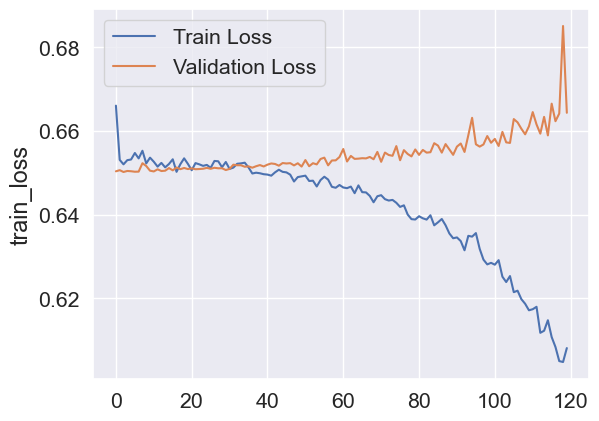

/Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lsy/opt/anaconda3/envs/csi_project/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

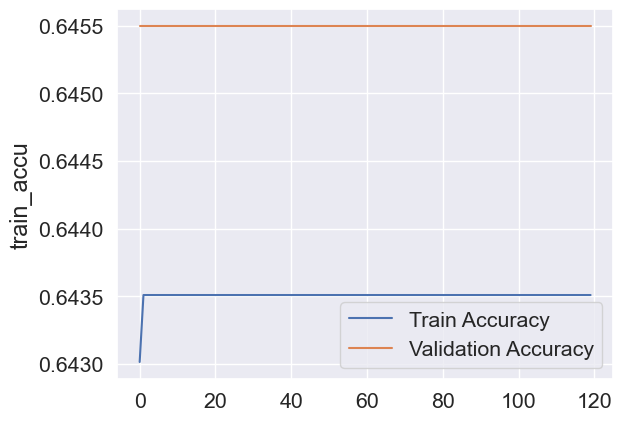

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot the training and validation losses
train_perf = pd.DataFrame({'train_loss': train_loss, 'val_loss': val_loss})
sns.lineplot(data=train_perf, y='train_loss', x=train_perf.index, label='Train Loss')
sns.lineplot(data=train_perf, y='val_loss', x=train_perf.index, label='Validation Loss')
plt.show()

# Plot the training and validation accuracies
plt.figure()
train_perf = pd.DataFrame({'train_accu': train_accu, 'val_accu': val_accu})
sns.lineplot(data=train_perf, y='train_accu', x=train_perf.index, label='Train Accuracy')
sns.lineplot(data=train_perf, y='val_accu', x=train_perf.index, label='Validation Accuracy')
plt.show()

Test Accuracy: 0.6244239631336406


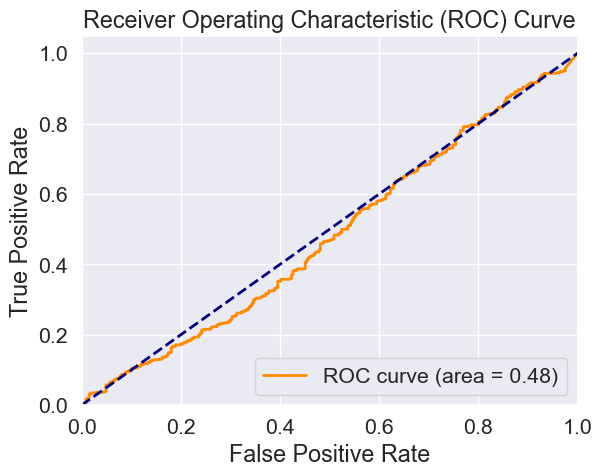

In [101]:
# predict on test set
test_pred, test_target, test_image = test(model, test_loader)
print(f"Test Accuracy: {calc_accuracy(test_pred, test_target)}")

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_target, test_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [102]:
import random

def visualize_image_gallery(images, rows, cols):
    
    if len(images) < rows * cols:
        empty_images = np.repeat(np.zeros_like(images[0])[np.newaxis,...], len(images - rows * cols), axis=0)
        images = np.concatenate((images, empty_images), axis=0)
        
    elif len(images) > rows * cols:
        images = images[random.sample(range(len(images)), rows * cols)]

    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    fig.subplots_adjust(wspace=1, hspace=1)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

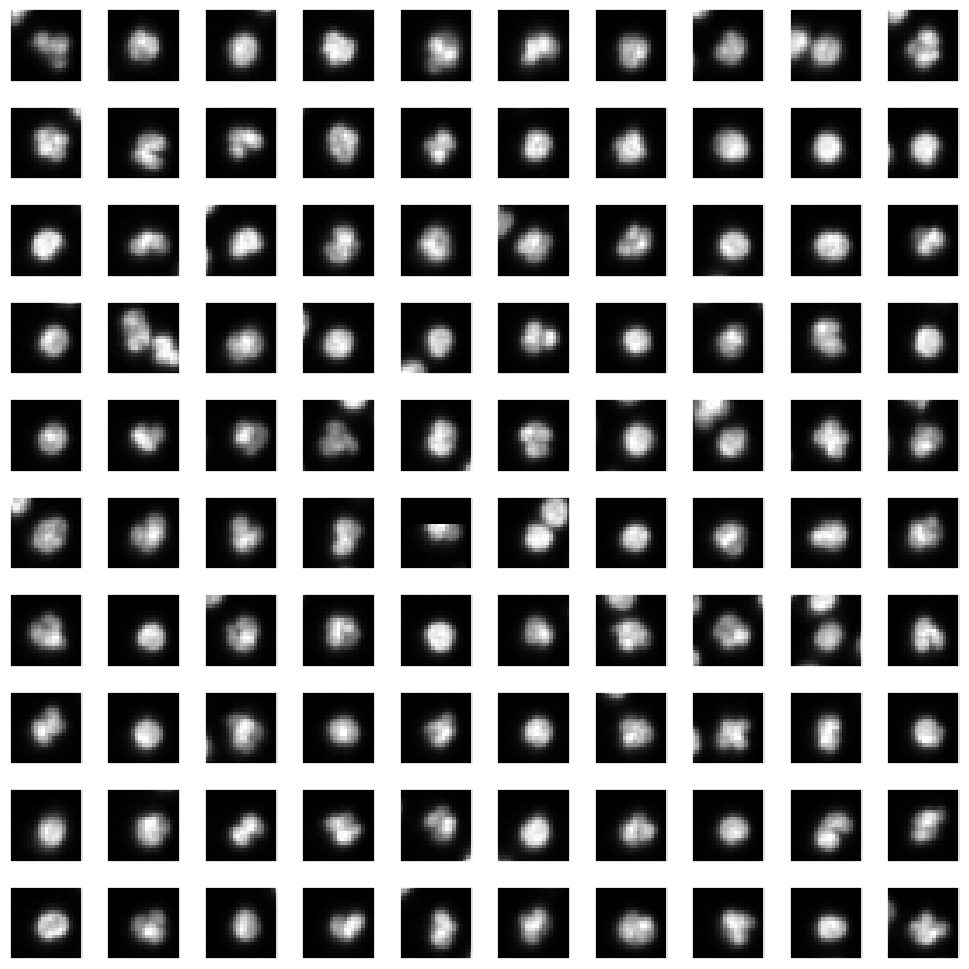

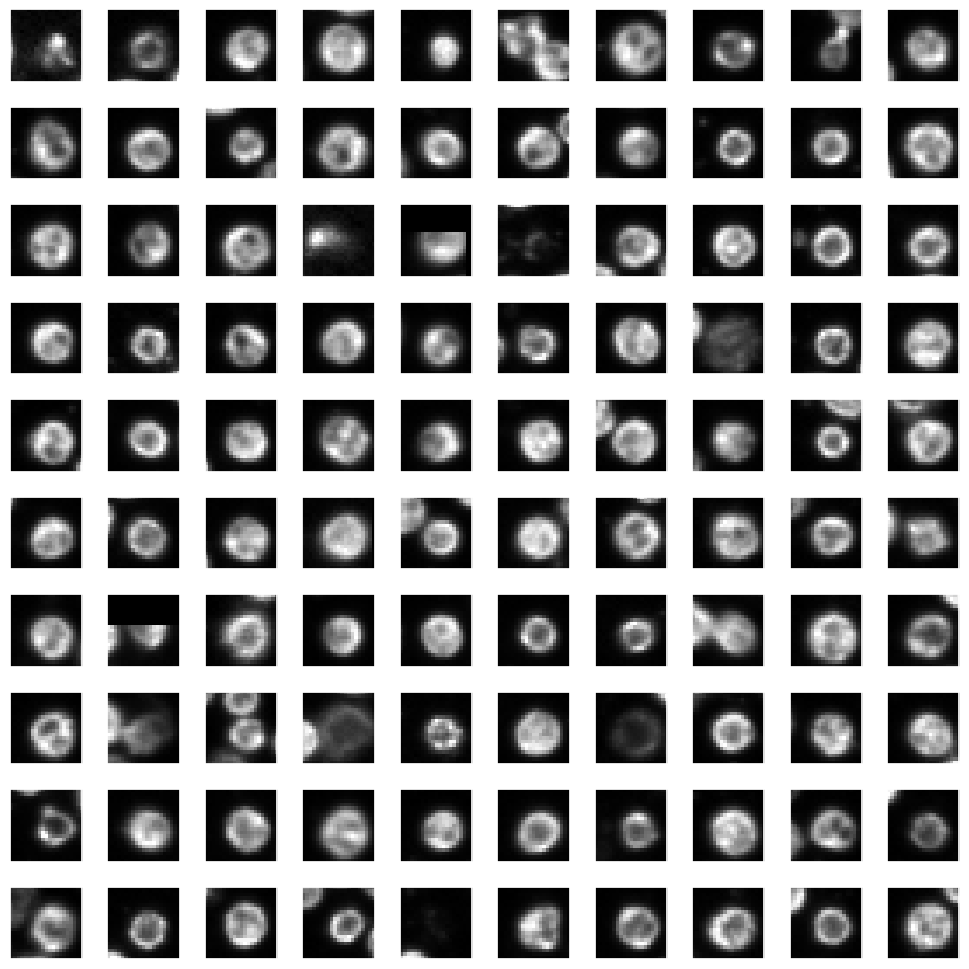

In [103]:
# Visualize the first 25 images in the test set
# lymph_index = np.where(test_target == 1)[0]
# visualize_image_gallery(test_image[lymph_index, 0, :, :], 10, 10)
# visualize_image_gallery(test_image[lymph_index, 1, :, :], 10, 10)

myeloid_index = np.where(test_target == 0)[0]
visualize_image_gallery(test_image[myeloid_index, 0, :, :], 10, 10)
visualize_image_gallery(test_image[myeloid_index, 1, :, :], 10, 10)

In [104]:
torch.save(model.state_dict(), '0B11619_10x_model.pth')

In [105]:
# comments
# class HDF5Dataset(Dataset):
#     def __init__(self, file_path, transform=None):
#         self.file_path = file_path
#         self.transform = transform
        
#         # Open the HDF5 file
#         with h5py.File(file_path, 'r') as file:
#             self.images = file['images'][:]
            
#         self.images = self.images[:, 1:, 1:, :] / 65535.0
#         self.targets = pd.read_hdf(file_path, key='features',
#                                    mode='r')['target'].values

#         # Get the number of samples in the dataset
#         self.num_samples = len(self.targets)

#     def __getitem__(self, index):
#         # Get the image and target from the HDF5 file
#         image = self.images[index]
#         target = self.targets[index]

#         # Convert the image and target to PyTorch tensors
#         image = torch.from_numpy(image).float()
#         target = torch.from_numpy(target).float()

#         # Apply any data augmentations or transformations
#         if self.transform is not None:
#             image = self.transform(image)

#         return image, target

#     def __len__(self):
#         return self.num_samples

In [106]:
model.eval()  # Set the model to evaluation mode
test_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predicted = outputs.round()  # Assuming your model outputs probabilities that need to be rounded to 0 or 1
        test_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())


from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_labels, predicted_labels)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 62.44%


[[  0 326]
 [  0 542]]


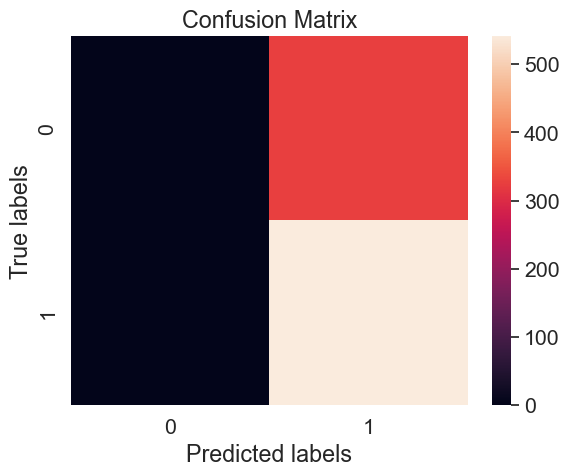

In [107]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_labels, predicted_labels)
print(conf_matrix)

# plot the confusion matrix for a visual representation
sns.heatmap(conf_matrix, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
